<a href="https://colab.research.google.com/github/chigvintseva/UniProject-AST/blob/main/ast_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [5]:
!pip install ace_tools

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Data generaion

## Main setup

In [9]:
np.random.seed(42)
random.seed(42)

num_people = 150
floors = ['Floor 1', 'Floor 2', 'Floor 3']
timestamps = pd.date_range(start='2025-06-12 09:00:00', periods=60, freq='min')

## Infrastructure coords (based on graphs)

In [12]:
exit_coords = {
    'Floor 1': [(2, 15), (27, 15)],
    'Floor 2': [],
    'Floor 3': []
}

stair_coords = {
    'Floor 1': [(2, 2), (27, 27)],
    'Floor 2': [(2, 2), (27, 27)],
    'Floor 3': [(2, 2), (27, 27)]
}

alarm_coords = {
    'Floor 1': [(2, 28), (28, 2)],
    'Floor 2': [(2, 28), (28, 2)],
    'Floor 3': [(2, 28), (28, 2)]
}

smoke_detectors_coords = {
    'Floor 1': [(10, 10), (10, 20), (20, 10), (20, 20)],
    'Floor 2': [(10, 10), (10, 20), (20, 10), (20, 20)],
    'Floor 3': [(10, 10), (10, 20), (20, 10), (20, 20)]
}

fire_detectors_coords = {
    'Floor 1': [(5, 5), (5, 25), (25, 5), (25, 25)],
    'Floor 2': [(5, 5), (5, 25), (25, 5), (25, 25)],
    'Floor 3': [(5, 5), (5, 25), (25, 5), (25, 25)]
}

crowd_sensors_coords = {
    'Floor 1': [(15, 8), (15, 22)],
    'Floor 2': [(15, 8), (15, 22)],
    'Floor 3': [(15, 8), (15, 22)]
}

## Generation of dataframes with main variables

In [16]:
df = pd.DataFrame({
    'person_id': range(1, num_people + 1),
    'timestamp': np.random.choice(timestamps, num_people),
    'floor': np.random.choice(floors, num_people),
    'location_x': np.random.randint(0, 30, num_people),
    'location_y': np.random.randint(0, 30, num_people),
    'alarm_status': np.random.choice(['OFF', 'ON'], num_people, p=[0.9, 0.1])
})

### Fire centers (will be modified in the future)

In [17]:
fire_centers = {
    'Floor 1': (5, 25),
    'Floor 2': (15, 15),
    'Floor 3': (25, 5)
}


### Smoke level variable generation (based on the fire center in the future)

In [18]:
def compute_smoke_level(row):
    fx, fy = fire_centers[row['floor']]
    dist = np.sqrt((row['location_x'] - fx)**2 + (row['location_y'] - fy)**2)
    return round(np.clip(1 - dist / 30, 0, 1), 2)

In [19]:
df['smoke_level'] = df.apply(compute_smoke_level, axis=1)
df.sort_values(by='timestamp', inplace=True)

## Additional dataset modernisations


In [41]:
if 'panic_factor' not in df.columns:
    df['panic_factor'] = np.clip(np.random.normal(1.0, 0.3, len(df)), 0.5, 2.0)
if 'crowd_sensitivity' not in df.columns:
    df['crowd_sensitivity'] = np.clip(np.random.normal(1.0, 0.2, len(df)), 0.6, 1.4)

In [42]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Data visualisation

## Head and tail

In [43]:
print("\n--- HEAD ---")
print(df.head())
print("\n--- TAIL ---")
print(df.tail())


--- HEAD ---
     person_id           timestamp    floor  location_x  location_y  \
127        128 2025-06-12 09:00:00  Floor 2           0          16   
122        123 2025-06-12 09:00:00  Floor 3           0          28   
82          83 2025-06-12 09:01:00  Floor 2          12          25   
66          67 2025-06-12 09:01:00  Floor 2           7          14   
26          27 2025-06-12 09:01:00  Floor 2          19          11   

    alarm_status  smoke_level  panic_factor  crowd_sensitivity  
127          OFF         0.50      0.760529           1.248394  
122          OFF         0.00      0.598647           0.982847  
82           OFF         0.65      0.902988           0.818061  
66           OFF         0.73      0.501965           1.127725  
26           OFF         0.81      1.518324           1.043172  

--- TAIL ---
     person_id           timestamp    floor  location_x  location_y  \
70          71 2025-06-12 09:59:00  Floor 3           0          19   
102        10

## Bar chart - people per floor

In [44]:
floor_counts = df['floor'].value_counts().sort_index()
floor_df = pd.DataFrame({'floor': floor_counts.index, 'count': floor_counts.values})

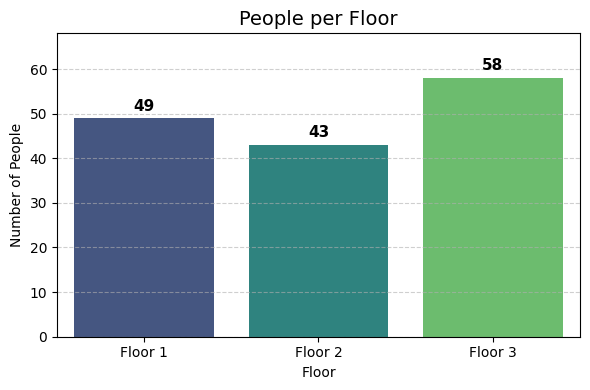

In [45]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=floor_df, x='floor', y='count', hue='floor', palette='viridis', legend=False)

for i, count in enumerate(floor_df['count']):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.title("People per Floor", fontsize=14)
plt.xlabel("Floor")
plt.ylabel("Number of People")
plt.ylim(0, max(floor_df['count']) + 10)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Heatmaps

In [46]:
def plot_markers(coords, color, marker, label, size=80):
    for i, (x, y) in enumerate(coords.get(floor, [])):
        if i == 0:
            plt.scatter(x, y, color=color, s=size, marker=marker, label=label)
        else:
            plt.scatter(x, y, color=color, s=size, marker=marker)

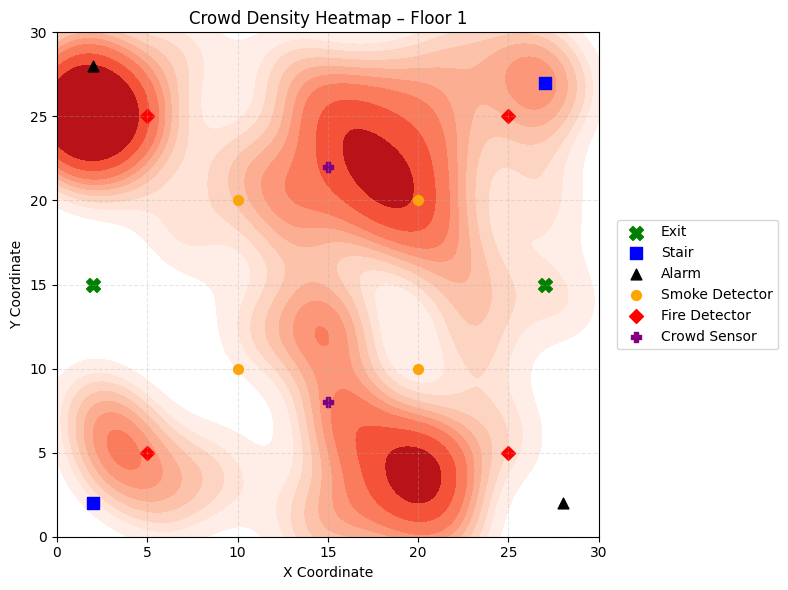

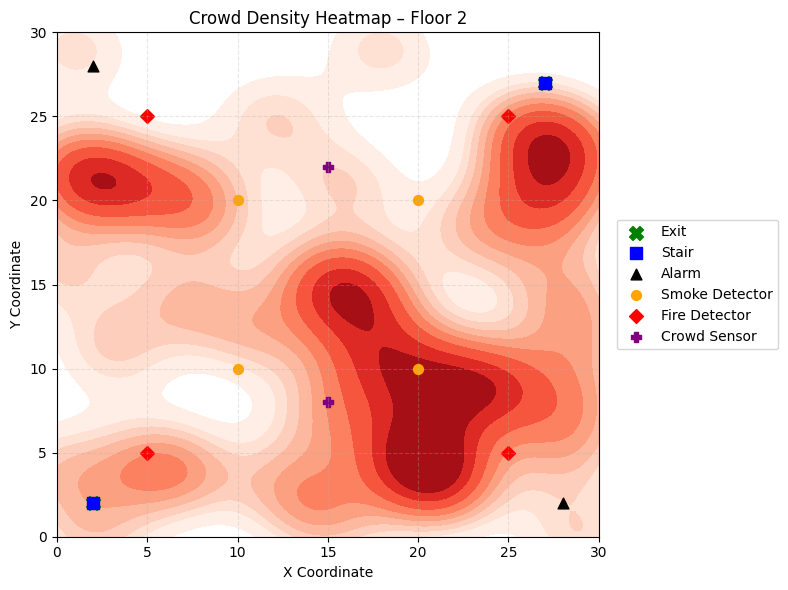

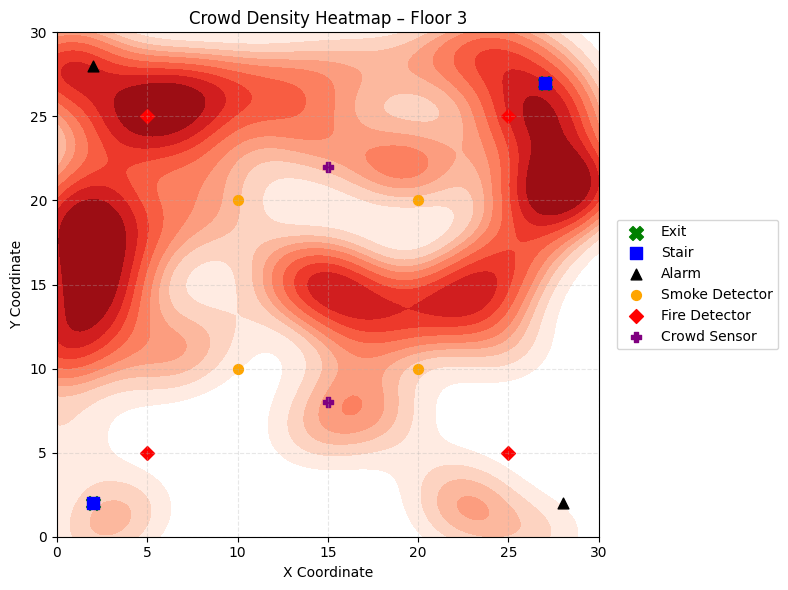

In [47]:

for floor in sorted(df['floor'].unique()):
    plt.figure(figsize=(8, 6))
    df_floor = df[df['floor'] == floor]
    sns.kdeplot(
        x=df_floor['location_x'],
        y=df_floor['location_y'],
        fill=True,
        cmap='Reds',
        bw_adjust=0.5,
        thresh=0.1
    )

    plot_markers(exit_coords, 'green', 'X', 'Exit', 100)
    plot_markers(stair_coords, 'blue', 's', 'Stair', 80)
    plot_markers(alarm_coords, 'black', '^', 'Alarm', 60)
    plot_markers(smoke_detectors_coords, 'orange', 'o', 'Smoke Detector', 50)
    plot_markers(fire_detectors_coords, 'red', 'D', 'Fire Detector', 50)
    plot_markers(crowd_sensors_coords, 'purple', 'P', 'Crowd Sensor', 50)

    plt.title(f'Crowd Density Heatmap – {floor}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    plt.show()

# Simulation

# ABM

In [48]:
def simulate_abm(df, scenario='control'):
    results = []
    for _, p in df.iterrows():
        x, y = p['location_x'], p['location_y']
        floor = p['floor']
        smoke = p['smoke_level']
        panic = p['panic_factor']
        sens = p['crowd_sensitivity']
        exits = exit_coords[floor]
        target_exit = min(exits, key=lambda c: np.linalg.norm([x - c[0], y - c[1]]))
        dist = np.linalg.norm([x - target_exit[0], y - target_exit[1]])

        speed = 3.0 / panic
        if 'congestion' in scenario:
            crowd_penalty = 1 + sens * 0.5
            speed /= crowd_penalty
        if 'stress' in scenario:
            speed /= (1 + smoke * 1.5)

        time = int(dist / max(0.3, speed))
        results.append({
            'person_id': p['person_id'], 'floor': floor,
            'evacuation_time': time, 'evacuated': time < 300,
            'scenario': f'ABM {scenario.capitalize()}'
        })
    return pd.DataFrame(results)

# DES

In [49]:
def simulate_des(df, scenario='control'):
    results = []
    for _, p in df.iterrows():
        x, y = p['location_x'], p['location_y']
        floor = p['floor']
        exit_x, exit_y = exit_coords[floor][0]
        dist = np.linalg.norm([x - exit_x, y - exit_y])

        delay = 0
        if scenario == 'fixed':
            delay = 20 if p['alarm_status'] == 'OFF' else 0
        elif scenario == 'smoke':
            delay = 0 if p['alarm_status'] == 'ON' else int(10 + p['smoke_level'] * 20)
        elif scenario == 'broken':
            delay = 999 if p['alarm_status'] == 'OFF' else 0

        speed = 3.0 / p['panic_factor']
        total_time = delay + int(dist / max(0.3, speed))

        results.append({
            'person_id': p['person_id'], 'floor': floor,
            'evacuation_time': total_time,
            'evacuated': total_time <= 300,
            'scenario': f'DES {scenario.capitalize()}'
        })
    return pd.DataFrame(results)


# Run of simulations

In [50]:
abm_control = simulate_abm(df, 'control')
abm_congestion = simulate_abm(df, 'congestion')
abm_stress = simulate_abm(df, 'stress')
abm_combined = simulate_abm(df, 'combined')

des_control = simulate_des(df, 'control')
des_fixed = simulate_des(df, 'fixed')
des_smoke = simulate_des(df, 'smoke')
des_broken = simulate_des(df, 'broken')

## Validation

In [56]:
def validate_kpi(df, expected_avg=150):
    error = abs(df['evacuation_time'].mean() - expected_avg)
    print(f"Validation Error vs Drill: {error:.2f} seconds")

validate_kpi(abm_combined)
validate_kpi(des_smoke)

Validation Error vs Drill: 146.15 seconds
Validation Error vs Drill: 127.37 seconds


# KPIs

Combine

In [52]:
all_sim = pd.concat([
    abm_control, abm_congestion, abm_stress, abm_combined,
    des_control, des_fixed, des_smoke, des_broken
])

visualize

/tmp/ipython-input-53-171086427.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_sim, x='scenario', y='evacuation_time', palette='Set2')


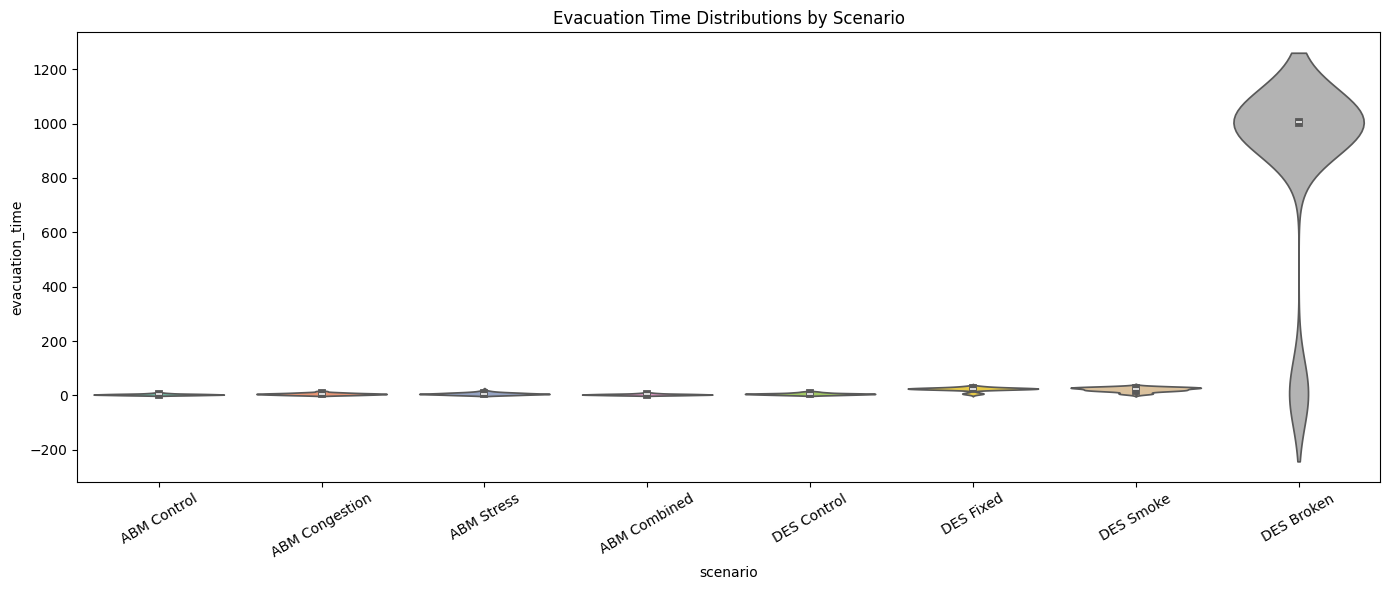

In [53]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=all_sim, x='scenario', y='evacuation_time', palette='Set2')
plt.xticks(rotation=30)
plt.title("Evacuation Time Distributions by Scenario")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

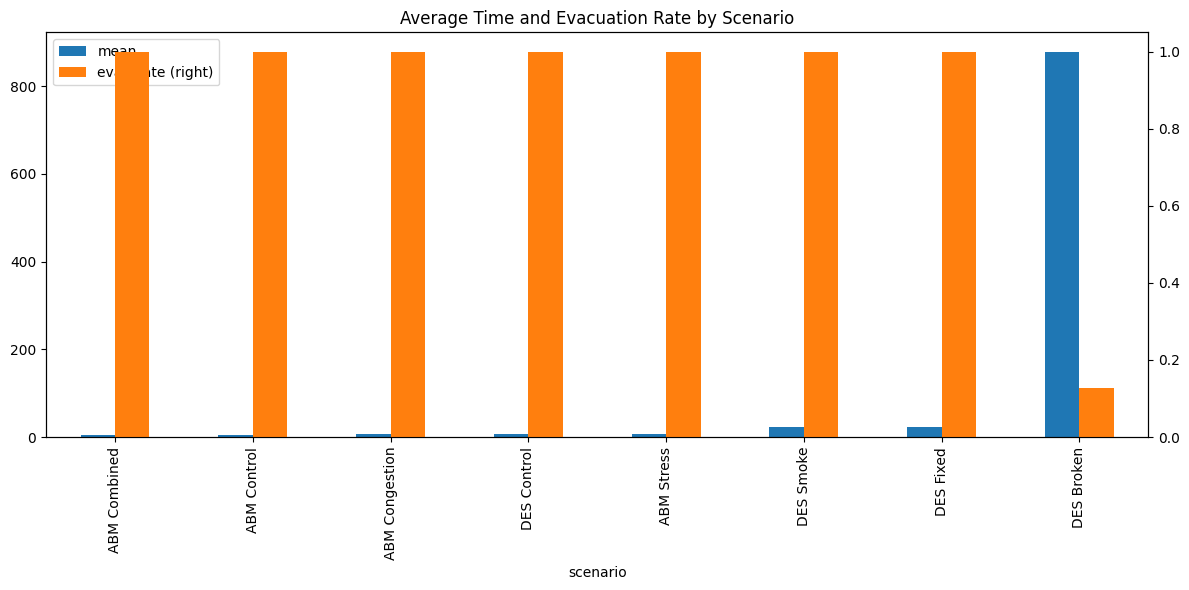

In [55]:
plt.figure(figsize=(12, 6))
kpi_summary = all_sim.groupby('scenario')['evacuation_time'].agg(['mean', 'median', 'std']).sort_values('mean')
kpi_summary['evac_rate'] = all_sim.groupby('scenario')['evacuated'].mean()
kpi_summary['fatality_rate'] = 1 - kpi_summary['evac_rate']
kpi_summary[['mean', 'evac_rate']].plot(kind='bar', secondary_y='evac_rate', figsize=(12, 6))
plt.title("Average Time and Evacuation Rate by Scenario")
plt.tight_layout()
plt.show()